In multivariate failure time data, individuals included in the study experience more than one outcome event during the observation period, and there is some correlation between multiple events in the same individual. Multiple outcome events may be of the same type such as loss tooth, or they may be of different types, such as fungal, bacterial or viral infections. Because the assumption that the time-to-event outcomes are independent of each other given the covariates does not hold, the popular Cox proportional hazards model cannot be applied directly to multivariate failure time data.

A marginal mixed baseline hazards model [1]_ was introduced for each type of failure with a proportional hazards model. The hazard function of the ith unit for the $k$-th type of failure is
$$\lambda_k(t;\mathbf{Z}_{ik})=\lambda_{0 k}(t)\exp^{\boldsymbol{\beta}^{\prime}\mathbf{Z}_{ik}},$$
where $\mathbf{Z}_{ik}$ is the covariates, $\lambda_{0 k}(t)$ are unspecified baseline hazard functions and $\boldsymbol{\beta}=(\beta_1,\ldots,\beta_p)^{\prime}$ is a $p\times 1$ vector of unknown regression parameters.

The log partial likelihood functions for $\boldsymbol{\beta}$ are
$$l_n(\boldsymbol{\beta})=\sum_{i=1}^n\sum_{k=1}^K \delta_{ik} \left\{\boldsymbol{\beta}^{\prime}\mathbf{Z}_{ik}-\log\left(\sum_{j=1}^n Y_{jk}(X_{ik})\exp^{\boldsymbol{\beta}^{\prime}\mathbf{Z}_{jk}}\right)\right\},$$
where $T_{ik}$, $C_{ik}$ and $X_{ik}=\min\{T_{ik}, C_{ik}\}$ is the survival time, censoring time and observed time, respctively. $\delta_{ik}=I(T_{ik}\leq C_{ik})$ is the censoring indicator and $Y_{ik}(t)=I(X_{ik}\geq t)$ is the corresponding at-risk indicator. 

In simulation part, similar to [1]_, we take $K=2$ and the failure times $T_{i1}, T_{i2}$ for the $i$ th individual are generated from the bivariate Clayton-Oakes distribution
$$P(T_{i1}>t_{i1},T_{i2}>t_{i2}|\boldsymbol{Z}_{i1},\boldsymbol{Z}_{i2})=\left[\sum_{k=1}^2 \exp\{t_{ik}\lambda_{0k}\theta^{-1}\exp(\boldsymbol{\beta}\boldsymbol{Z}_{ik})-1\}\right]^{-\theta},$$
where $\boldsymbol{Z}_{ik}$ has a normal distribution. $\theta\rightarrow 0$ gives the maximal positive correlation of 1 between failure times, and $\theta\rightarrow \infty$ corresponds to independence.

In [2]:
import numpy as np
import random
import jax.numpy as jnp
from scope import ScopeSolver

# Generate bivariate Clayton-Oakes distribution 
# c1,c2 control the censoring rate
# return the observed data and censoring indicator
def make_Clayton2_data(n, theta=15, lambda1=1, lambda2=1, c1=1, c2=1):
    u1 = np.random.uniform(0, 1, n)
    u2 = np.random.uniform(0, 1, n)
    time2 = -np.log(1-u2)/lambda2
    time1 = np.log(1-np.power((1-u2),-theta) + np.power((1-u1), -theta/(1+theta))*np.power((1-u2),-theta))/theta/lambda1
    ctime1 = np.random.uniform(0, c1, n)
    ctime2 =  np.random.uniform(0, c2, n)
    delta1 = (time1 < ctime1) * 1
    delta2 = (time2 < ctime2) * 1
    censoringrate1 = 1 - sum(delta1) / n
    censoringrate2 = 1 - sum(delta2) / n
    print("censoring rate1:" + str(censoringrate1))
    print("censoring rate2:" + str(censoringrate2))
    time1 = np.minimum(time1,ctime1)
    time2 = np.minimum(time2,ctime2)
    y = np.hstack((time1.reshape((-1, 1)), time2.reshape((-1, 1))))
    delta = np.hstack((delta1.reshape((-1, 1)), delta2.reshape((-1, 1))))
    return(y,delta)


[2]_ proposed a penalised pseudo-partial likelihood method for variable selection with multivariate failure time data. Here, under sparsity constraint, we can estimate $\boldsymbol{\beta}$ by minimizing the negative log partial likelihood function:
$$arg\min_{\beta \in R^p}~-l_n(\boldsymbol{\beta}) , s.t.  || \boldsymbol{\beta} ||_0 \leq s.$$

Firstly, generate the data as described above and plot Kaplan-Meier survival curves. Then, perform a log-rank test to compare the survival curves of the two groups. The following results show that there is a significant difference between the survival curves.

censoring rate1:0.52
censoring rate2:0.32999999999999996


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.88 0.01      6.84

None


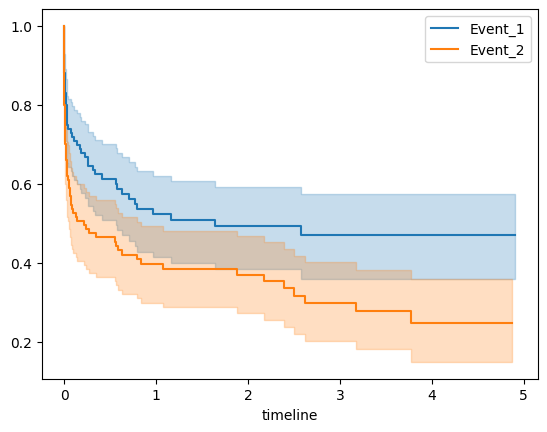

In [3]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

n, p, k, rho = 100, 10, 2, 0.5
beta = np.zeros(p)
supportset = random.sample(range(0,p),k)
beta[supportset] = np.random.uniform(2, 5, k)
Sigma = np.power(rho, np.abs(np.reshape(np.array([i-j for i in np.arange(1,p+1) for j in np.arange(1,p+1)]) ,newshape=(p,p))))
x = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=(n,))
lambda1 = 1*np.exp(np.matmul(x, beta))
lambda2 = 10*np.exp(np.matmul(x, beta))

y, delta = make_Clayton2_data(n, theta=50, lambda1=lambda1, lambda2=lambda2, c1=5, c2=5)


kmf = KaplanMeierFitter()
for i in range(0, 2):
    event_name = 'Event_' + str(i+1)
    kmf.fit(y[:,i], delta[:,i], label=event_name, alpha=0.05)
    kmf.plot()

results = logrank_test(y[:,0], y[:,1], delta[:,0], delta[:,1])
print(results.print_summary())

A python code for solving such model is as following: 

In [4]:
def multivariate_failure_objective(params):
    Xbeta = jnp.matmul(x, params)
    logsum1 = jnp.zeros_like(Xbeta)
    logsum2 = jnp.zeros_like(Xbeta)
    for i in range(0,n):
        logsum1 = logsum1.at[i].set(jnp.log(jnp.dot(y[:,0] >= y[:,0][i], jnp.exp(Xbeta))))
        logsum2 = logsum2.at[i].set(jnp.log(jnp.dot(y[:,1] >= y[:,1][i], jnp.exp(Xbeta))))
    return (jnp.dot(delta[:,0],logsum1)+jnp.dot(delta[:,1],logsum2)-jnp.dot(delta[:,0], Xbeta)-jnp.dot(delta[:,1], Xbeta))/n


solver = ScopeSolver(p, k)
solver.solve(multivariate_failure_objective, jit=True)

print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("True parameter:", beta, "objective:",multivariate_failure_objective(beta))

Estimated parameter: [1.90593256 0.         0.         0.         0.         0.
 0.         0.         4.15421484 0.        ] objective: 2.696540117263794
True parameter: [2.1068055  0.         0.         0.         0.         0.
 0.         0.         4.19790523 0.        ] objective: 2.7137153


The algorithm has selected the correct variables, and the estimated coefficients and loss are very close to the true values.

.. rubric:: References
.. [1] Clegg L X, Cai J, Sen P K. A marginal mixed baseline hazards model for multivariate failure time data[J]. Biometrics, 1999, 55(3): 805-812.
.. [2] Jianwen Cai and others, Variable selection for multivariate failure time data, Biometrika, Volume 92, Issue 2, June 2005, Pages 303–316